In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from scipy.stats import chi2_contingency, chisquare, chi2
from sknetwork.clustering import Louvain
from sklearn.feature_extraction.text import TfidfTransformer

import numpy as np

import matplotlib.pyplot as plt

In [2]:
datapath = Path("../data")

In [3]:
list(datapath.glob("*.txt"))

[PosixPath('../data/41467_2014_BFncomms5212_MOESM1046_ESM.txt'),
 PosixPath('../data/41467_2014_BFncomms5212_MOESM1045_ESM.txt')]

In [4]:
association_data = pd.read_csv(datapath/"41467_2014_BFncomms5212_MOESM1045_ESM.txt", sep = "\t")

In [5]:
association_data

MeSH Symptom Term                       MeSH Disease Term  \
0       Aging, Premature  Respiratory Syncytial Virus Infections   
1       Aging, Premature             Orthomyxoviridae Infections   
2       Aging, Premature                          HIV Infections   
3       Aging, Premature      Acquired Immunodeficiency Syndrome   
4       Aging, Premature                        Breast Neoplasms   
...                  ...                                     ...   
147973         Hirsutism                    Tobacco Use Disorder   
147974         Hirsutism                        Radius Fractures   
147975         Hirsutism                                   Burns   
147976         Hirsutism                        Colles' Fracture   
147977         Hirsutism                      Radiation Injuries   

        PubMed occurrence  TFIDF score  
0                       1     3.464551  
1                       1     3.464551  
2                       3    10.393654  
3                       3    10.393654  
4                       1     3.464551  
...                   ...          ...  
147973                  1     2.483722  
147974                  1     2.483722  
147975                  1     2.483722  
147976                  1     2.483722  
147977                  1     2.483722  

[147978 rows x 4 columns]

In [6]:
symp = association_data["MeSH Symptom Term"].unique().tolist()
dise = association_data["MeSH Disease Term"].unique().tolist()
links = association_data[['MeSH Symptom Term', 'MeSH Disease Term', 'PubMed occurrence']]
links = [tuple(x) for x in links.values]

In [7]:
biadjacency_data = association_data.pivot(index = "MeSH Disease Term", columns = "MeSH Symptom Term", values = "PubMed occurrence").fillna(0).astype(int)
biadjacency_matrix = biadjacency_data.values
scaled_biadjacency_matrix = TfidfTransformer().fit_transform(biadjacency_matrix)

# Create Graph

In [8]:
G = nx.Graph()

In [9]:
from scipy import sparse
#G.add_nodes_from(dise, bipartite = 0)
#G.add_nodes_from(symp, bipartite = 1)
G = nx.bipartite.from_biadjacency_matrix(sparse.csr_matrix(biadjacency_data.values))

In [10]:
#G.add_weighted_edges_from(links)

In [11]:
#biadjacency = nx.bipartite.biadjacency_matrix(G, row_order = dise, column_order=symp)

In [191]:
from tqdm import tqdm
def link_chi2(biadjacency_matrix):
    idxs = list(zip(*sparse.coo_matrix(biadjacency_matrix).nonzero()))
    if sparse.issparse(biadjacency_matrix):
        biadjacency_matrix = biadjacency_matrix.A
    total = biadjacency_matrix.sum()

    total_disease = biadjacency_matrix.sum(1)
    total_symptom = biadjacency_matrix.sum(0)

    compl_disease = total - total_disease
    compl_symptom = total - total_symptom    
    
    p_values = []
    for i in tqdm(idxs):
        td = total_disease[i[0]]
        ts = total_symptom[i[1]]
        
        has_d_and_s = biadjacency_matrix[i[0], i[1]]
        has_d_no_s = td - has_d_and_s
        no_d_has_s = ts - has_d_and_s
        no_d_no_s = total - (has_d_and_s + has_d_no_s + no_d_has_s)
        
        table = np.array([[no_d_no_s, no_d_has_s],[has_d_no_s, has_d_and_s]])
        chi2_s,p,ddof, exp = chi2_contingency(table)
        p_values.append(p)
    return np.array(p_values)


def plot_graph(G, **kwargs):
    #clusters = Louvain().fit_transform(nx.to_scipy_sparse_matrix(G)) 
    #colors = plt.get_cmap("tab20")(clusters)
    #weights = np.array([i[2] for  i in (G.edges.data("weight"))])
    fig, ax = plt.subplots()
    nx.draw(
        G,
        ax = ax,
    #    width = weights,
    #    node_color = colors
    )
    plt.subplots_adjust(-4,-4)
    return fig

In [13]:
scaled_biadjacency_matrix

<4219x322 sparse matrix of type '<class 'numpy.float64'>'
	with 147978 stored elements in Compressed Sparse Row format>

In [14]:
p_values = link_chi2(biadjacency_matrix)

100%|█████████████████████████████████| 147978/147978 [00:43<00:00, 3408.18it/s]


In [15]:
(p_values <= .05).sum()

55953

In [16]:
filtered_scaled_biadjacency_matrix = scaled_biadjacency_matrix.copy()
filtered_scaled_biadjacency_matrix.data = np.where(p_values <= 0.05, filtered_scaled_biadjacency_matrix.data, 0)
filtered_scaled_biadjacency_matrix.eliminate_zeros()

In [17]:
scaled_biadjacency_matrix,filtered_scaled_biadjacency_matrix

(<4219x322 sparse matrix of type '<class 'numpy.float64'>'
 	with 147978 stored elements in Compressed Sparse Row format>,
 <4219x322 sparse matrix of type '<class 'numpy.float64'>'
 	with 55953 stored elements in Compressed Sparse Row format>)

/home/alan/.local/share/virtualenvs/p3-XUfK0FVm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alan/.local/share/virtualenvs/p3-XUfK0FVm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribuição de pesos TFIDF (normalizados pela norma L2)')]

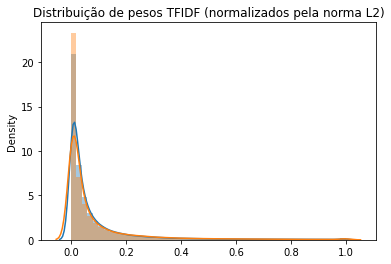

In [18]:
import seaborn as sns
plot = sns.distplot(scaled_biadjacency_matrix.data)
plot = sns.distplot(filtered_scaled_biadjacency_matrix.data)
plot.set(title = "Distribuição de pesos TFIDF (normalizados pela norma L2)")

In [19]:
d_d_adj = filtered_scaled_biadjacency_matrix@filtered_scaled_biadjacency_matrix.T
d_d_adj = sparse.csr_matrix(d_d_adj)
d_d_adj.setdiag(0)
d_d_adj.eliminate_zeros()

/home/alan/.local/share/virtualenvs/p3-XUfK0FVm/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [22]:
d_d_graph = nx.from_scipy_sparse_matrix(d_d_adj)

/tmp/ipykernel_102416/126186465.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  d_d_graph = nx.from_scipy_sparse_matrix(d_d_adj)


In [175]:
#fig1 = plot_graph(d_d_graph)

In [23]:
from backbone_network import get_graph_backbone
graph_backbone = get_graph_backbone(d_d_graph, alpha_t=0.05)

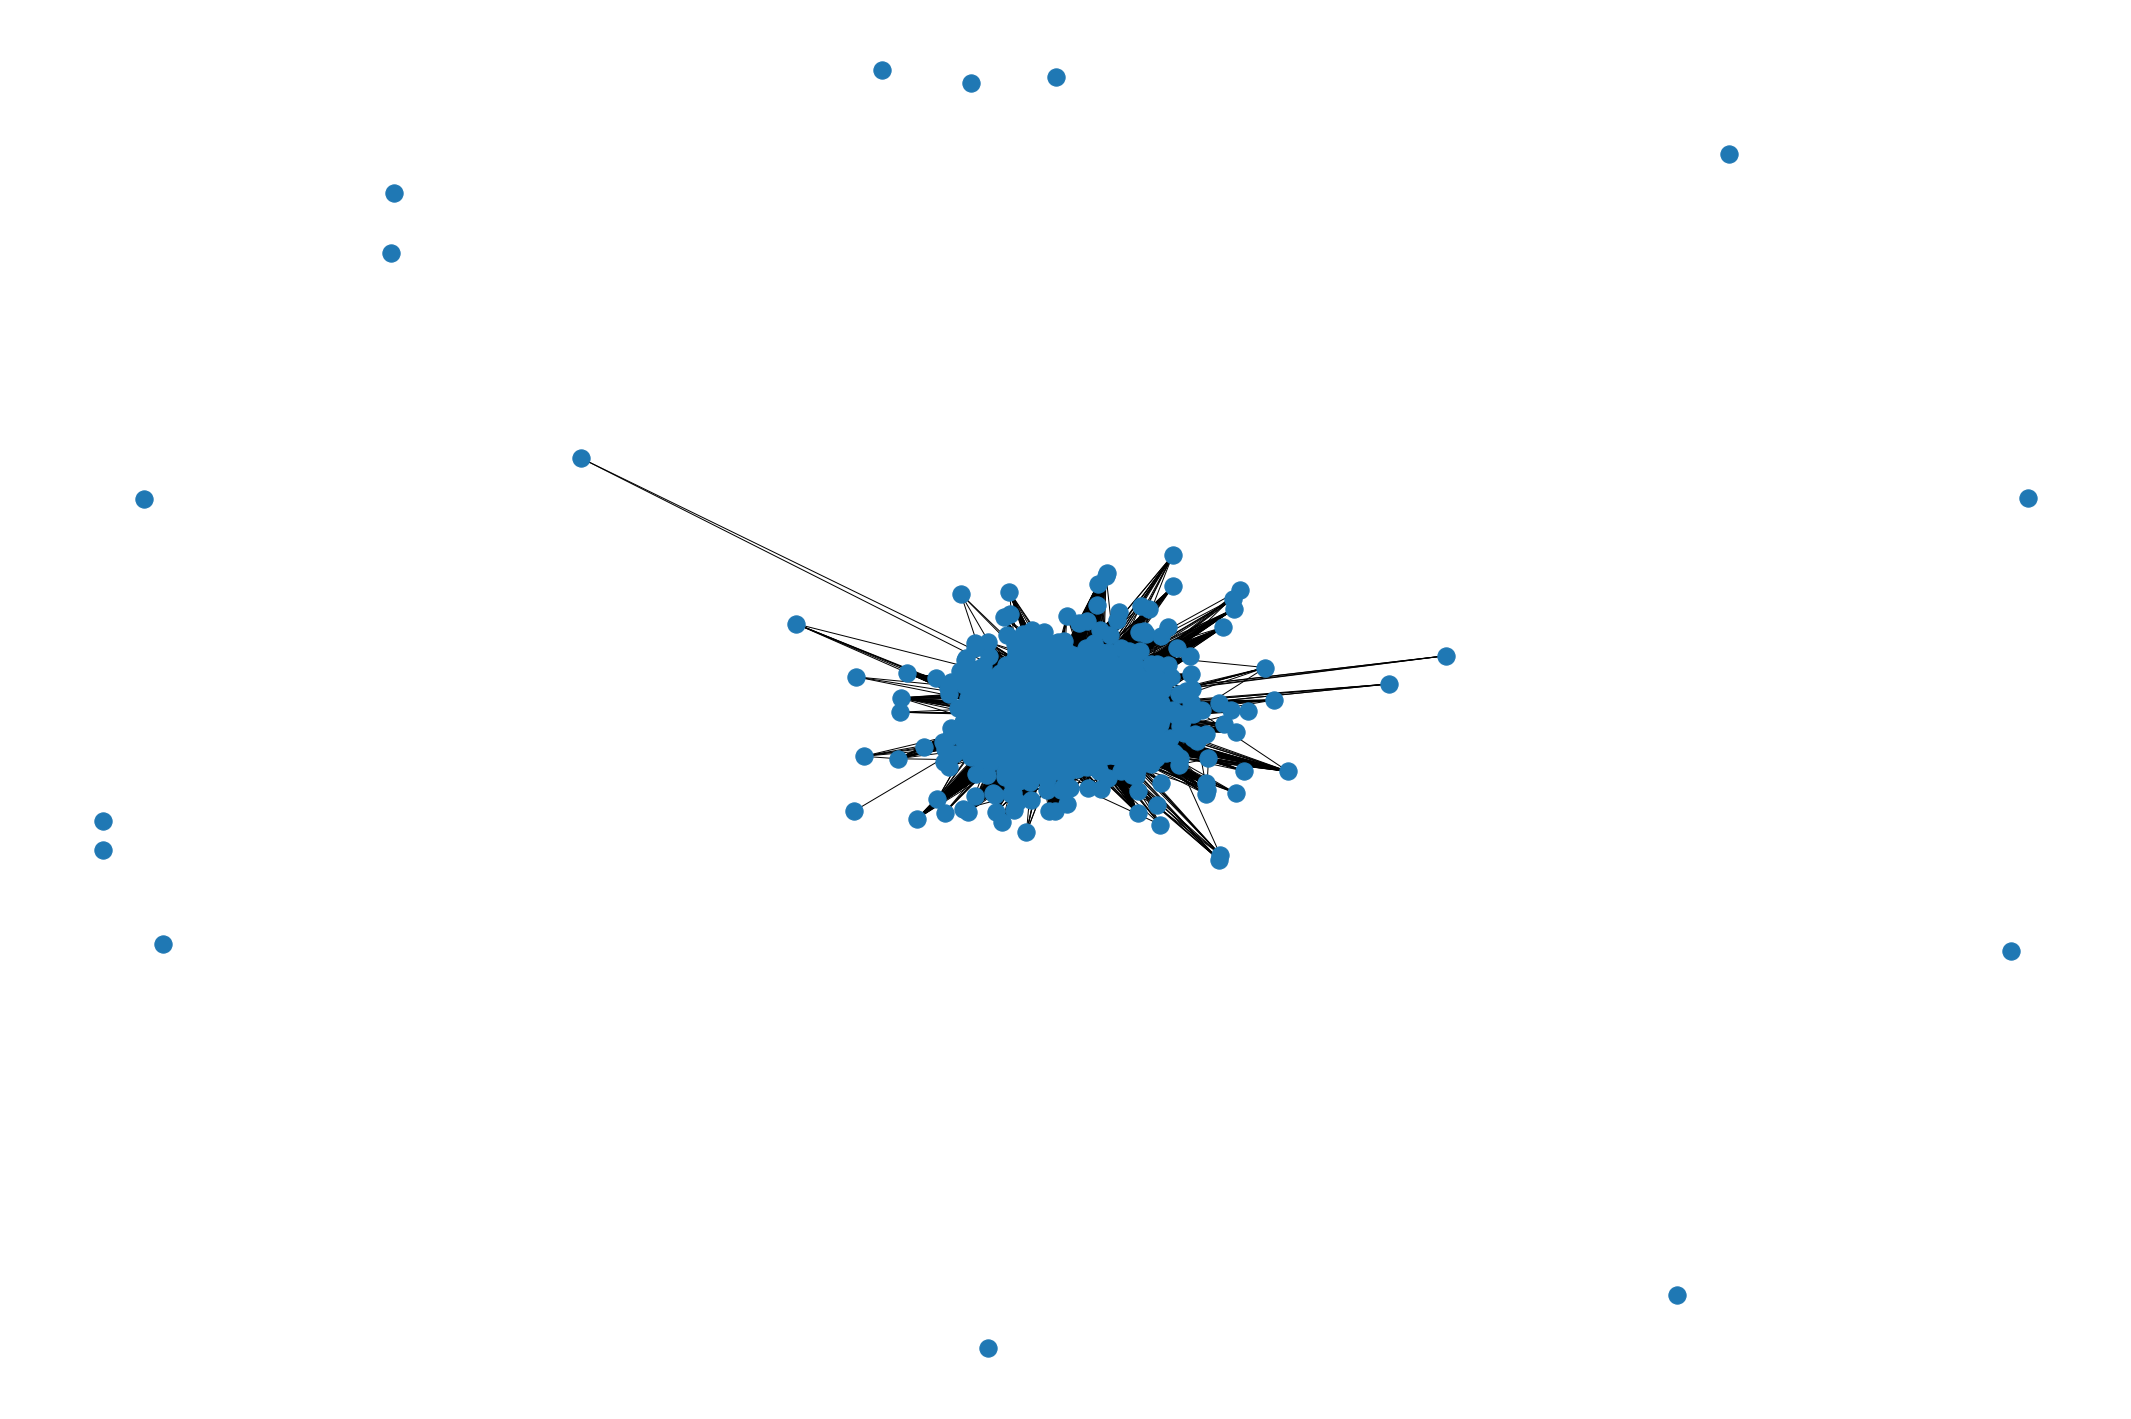

In [192]:
fig = plot_graph(graph_backbone)

In [194]:
fig.savefig("../files/backbone_graph.png", dpi = fig.dpi, bbox_inches='tight')

In [24]:
adj = nx.adjacency_matrix(graph_backbone)

/tmp/ipykernel_102416/2240969714.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(graph_backbone)


In [25]:
adj

<4219x4219 sparse matrix of type '<class 'numpy.float64'>'
	with 679188 stored elements in Compressed Sparse Row format>

/home/alan/.local/share/virtualenvs/p3-XUfK0FVm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

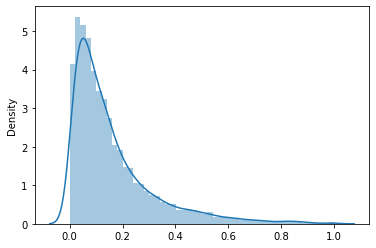

In [26]:
sns.distplot(np.random.choice(adj.data.flatten(), size = 10000))

In [29]:
graph_backbone.get_edge_data(0,17)

{'alpha': 0.0001, 'weight': 0.33858164409446534}

In [21]:
len(graph_backbone.edges),len(graph_backbone.nodes)

(340221, 4219)

In [58]:
centralities = nx.degree_centrality(graph_backbone)

In [59]:
#
node, centrality = [i for i in centralities], [v for v in centralities.values()]
centralities = pd.DataFrame([node,centrality]).T
centralities.columns = ["node","centrality"]
centralities["node"] = centralities["node"].astype(int)

In [60]:
selected_nodes = centralities.sort_values(by = "centrality", ascending = False).iloc[:422]

In [61]:
selected_nodes["node"]

477      477
379      379
518      518
776      776
314      314
        ... 
1940    1940
3346    3346
3203    3203
1434    1434
2977    2977
Name: node, Length: 422, dtype: int64

In [62]:
plot_subgraph = nx.subgraph(graph_backbone, selected_nodes["node"])

In [69]:
edge_centrality = nx.edge_betweenness_centrality(plot_subgraph)

In [72]:

edge, e_centrality = [i for i in edge_centrality], [v for v in edge_centrality.values()]
edge_centralities = pd.DataFrame([edge,centrality]).T
edge_centralities.columns = ["edge","centrality"]
edge_centralities = edge_centralities.sort_values(by = "centrality", ascending = False)

In [76]:
selected_edges = edge_centralities.iloc[:1635]

In [77]:
plot_subgraph_2 = nx.edge_subgraph(plot_subgraph, selected_edges["edge"])

In [150]:
weights = np.array([i[2] for  i in (plot_subgraph.edges.data("weight"))])

In [157]:
clusters = Louvain().fit_transform(nx.to_scipy_sparse_matrix(plot_subgraph)) 
colors = plt.get_cmap("tab20")(clusters)

/tmp/ipykernel_102416/3092380233.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  clusters = Louvain().fit_transform(nx.to_scipy_sparse_matrix(plot_subgraph))


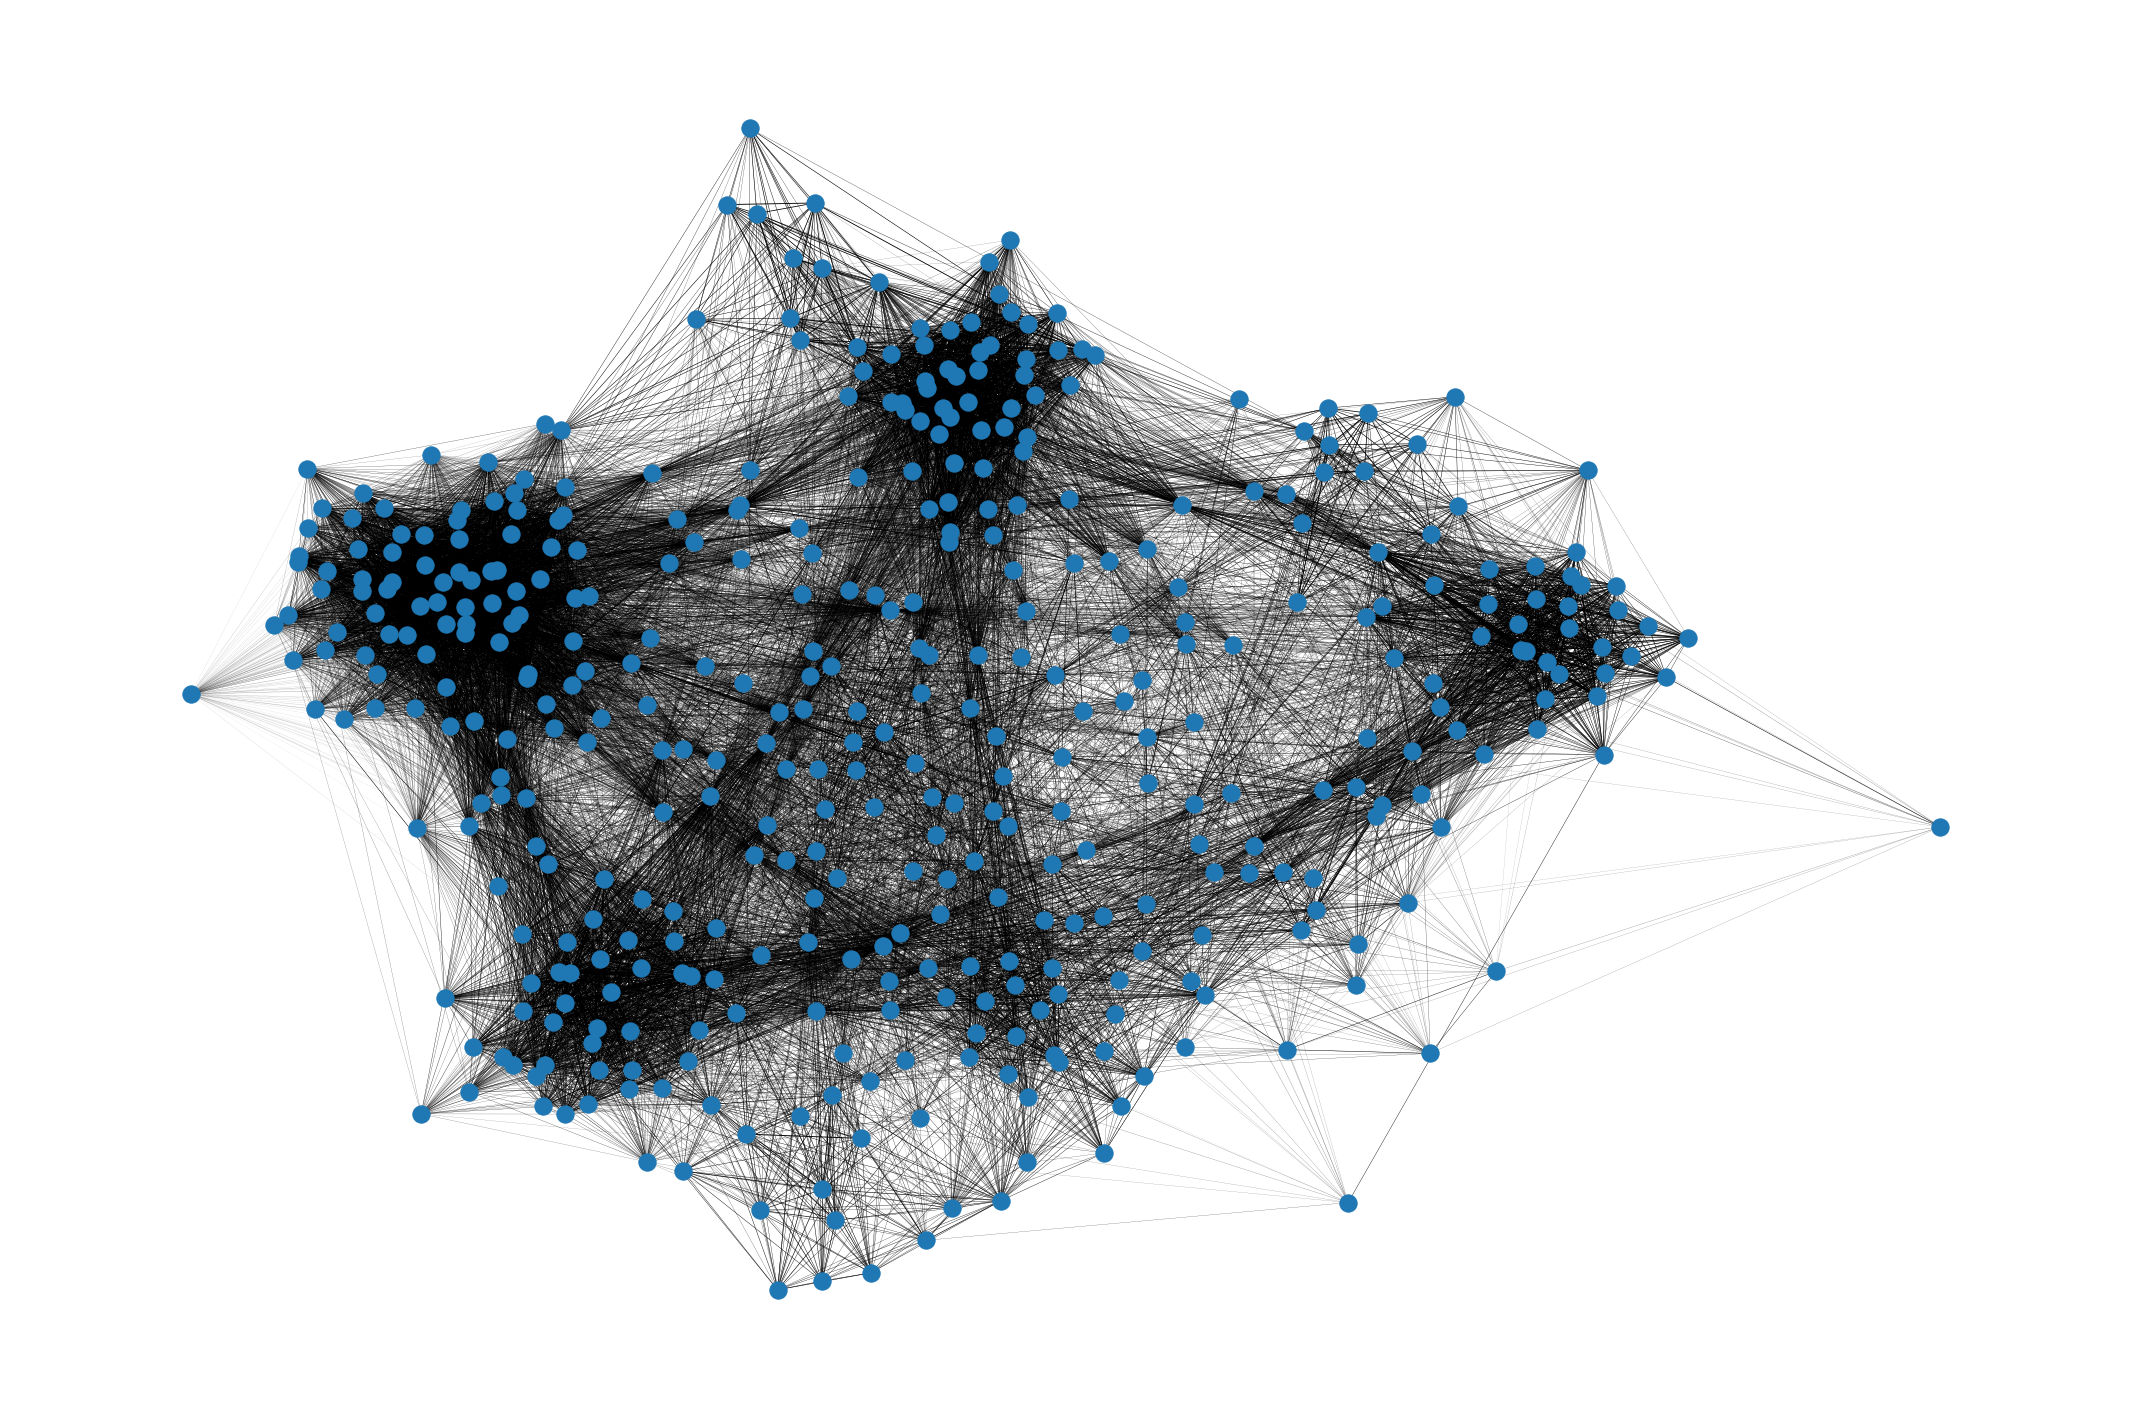

In [187]:
fig, ax = plt.subplots()
nx.draw(plot_subgraph, ax = ax, width = weights)
plt.subplots_adjust(-4,-4)
fig.savefig("../files/subgraph1.png", dpi = fig.dpi, bbox_inches='tight')

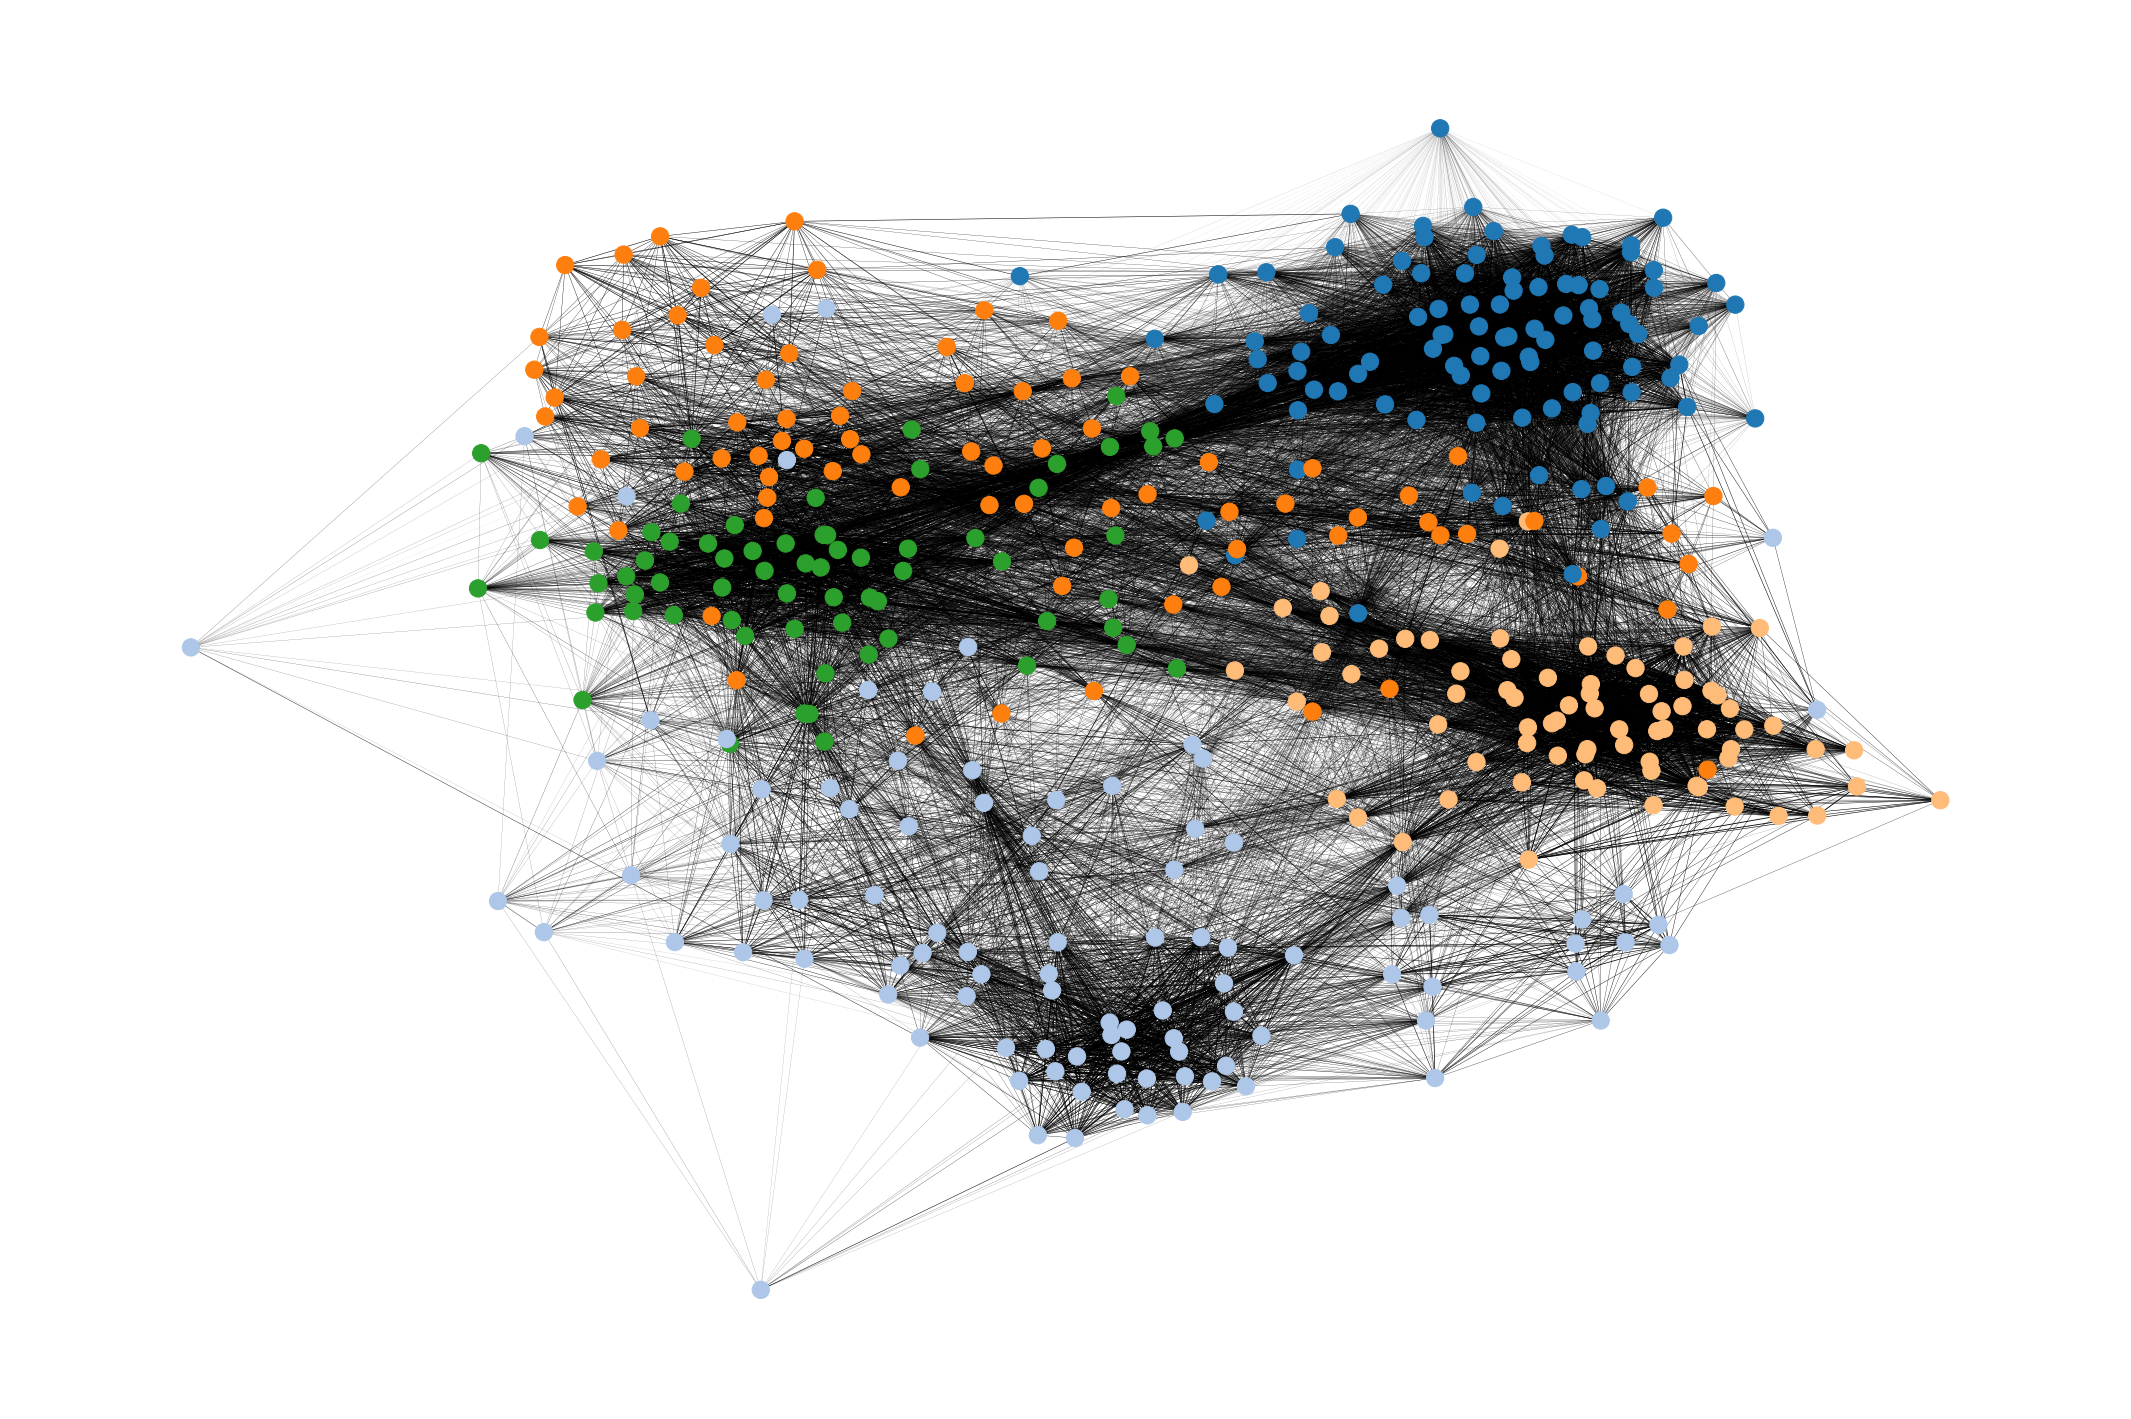

In [161]:
fig, ax = plt.subplots()
nx.draw(plot_subgraph, ax = ax, width = weights, node_color = colors)
plt.subplots_adjust(-4,-4)

In [152]:
weights2 = np.array([i[2] for  i in (plot_subgraph_2.edges.data("weight"))])

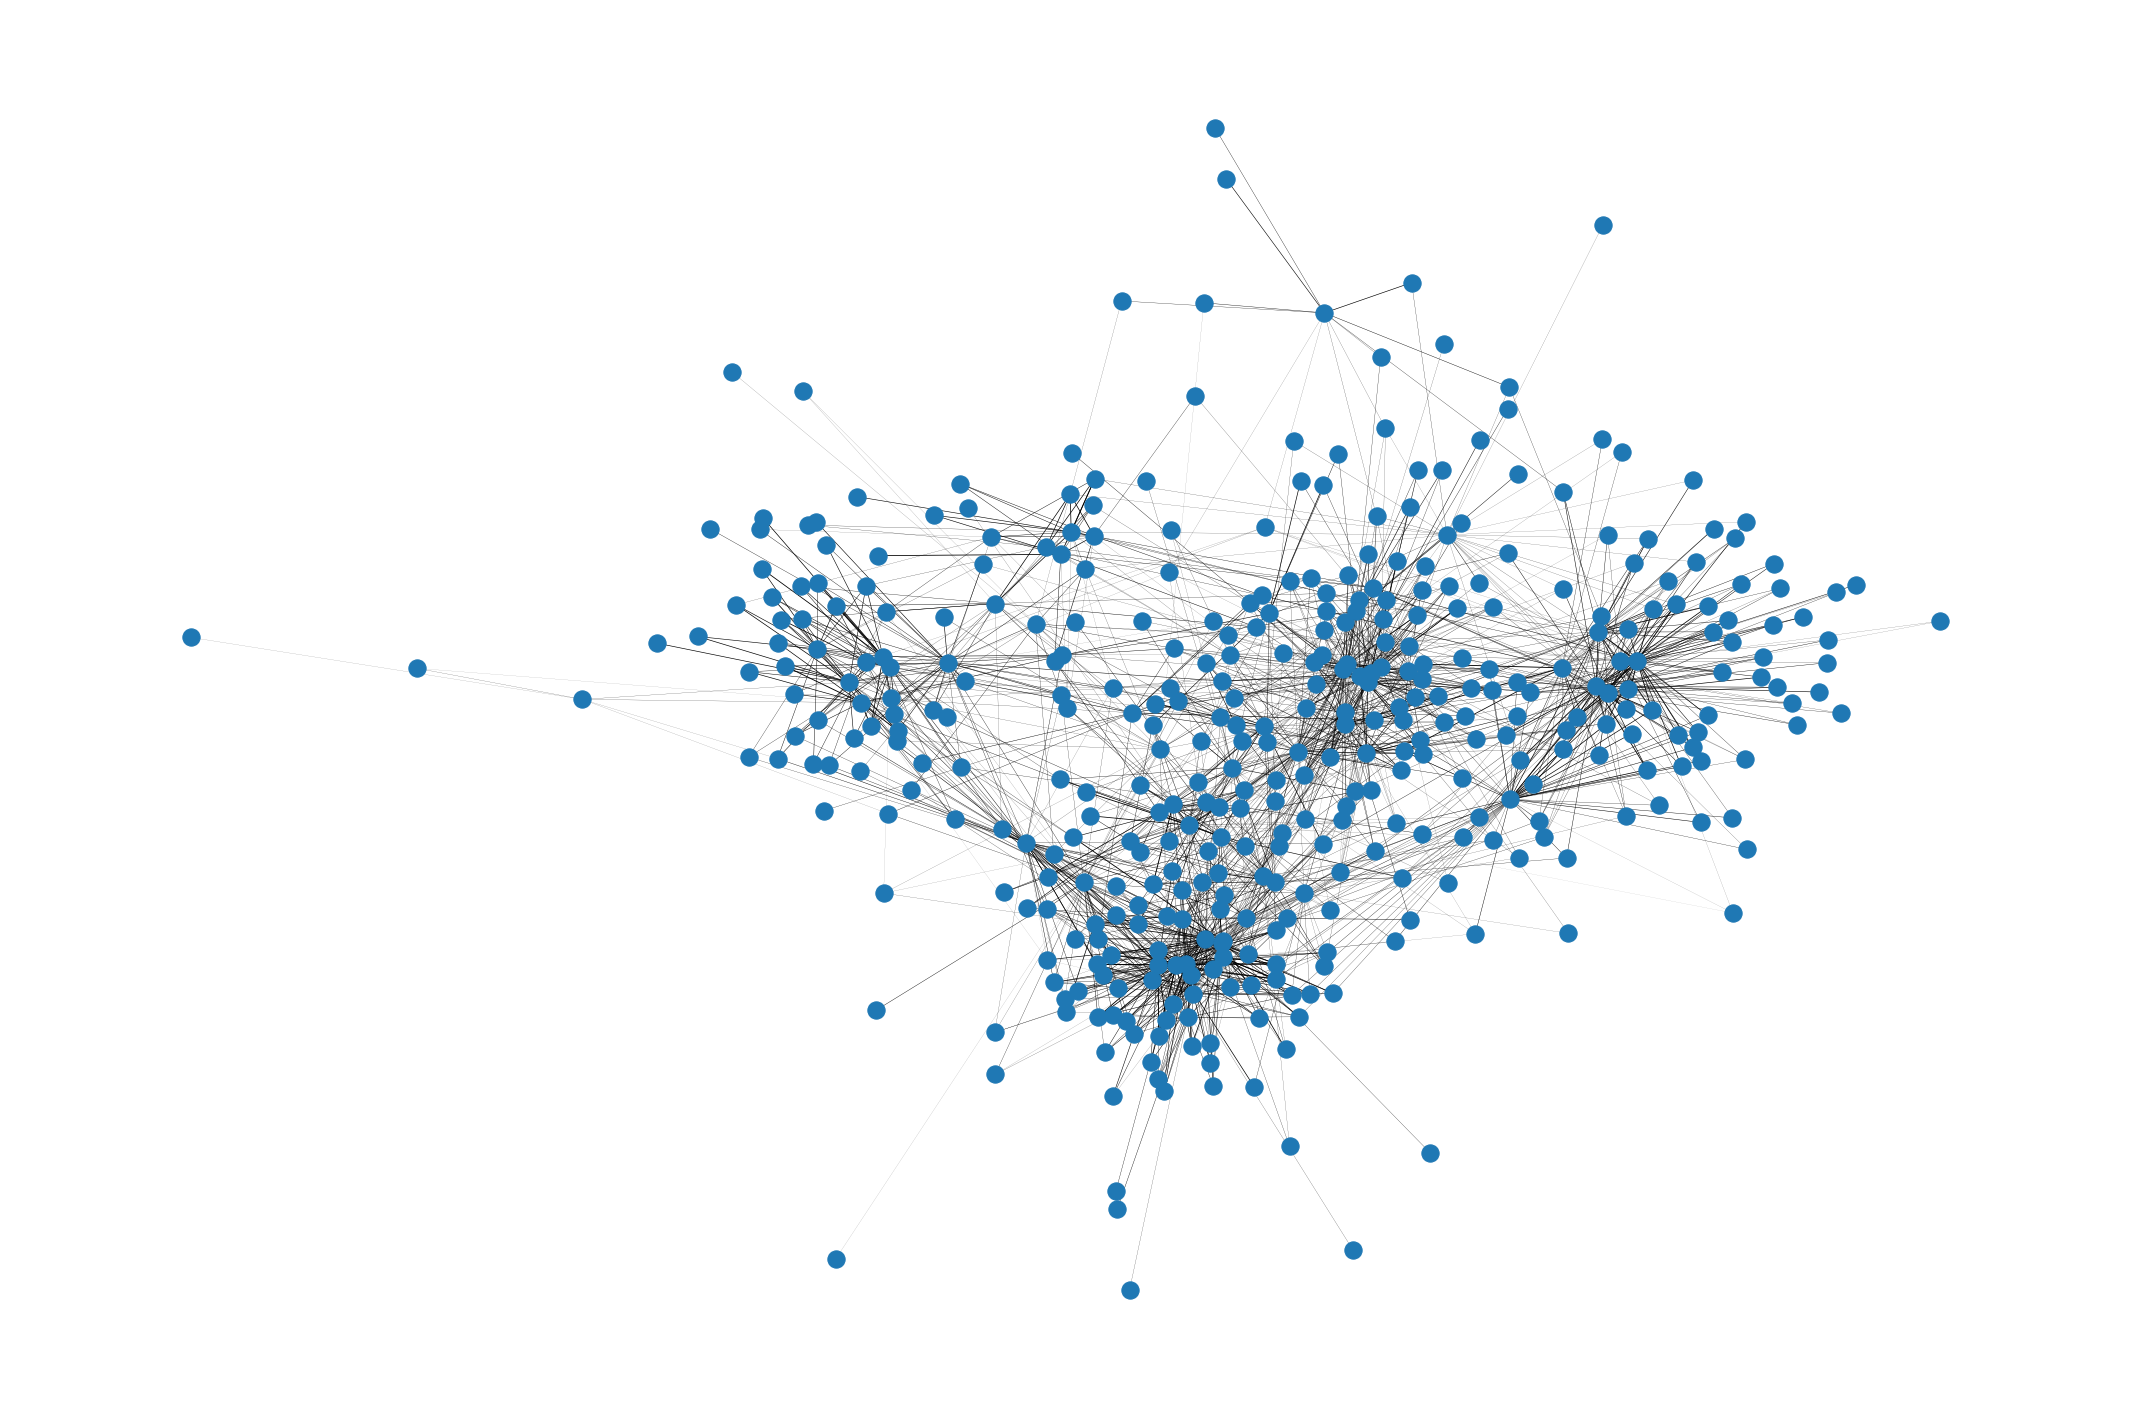

In [186]:
fig, ax = plt.subplots()
nx.draw(plot_subgraph_2, ax = ax, width = weights2)
plt.subplots_adjust(-4,-4)
fig.savefig("../files/subgraph2.png", dpi = fig.dpi, bbox_inches='tight')

In [154]:
#layout = nx.kamada_kawai_layout(graph_backbone)
#layout = nx.circular_layout(graph_backbone)

In [165]:
clusters2 = Louvain().fit_transform(nx.to_scipy_sparse_matrix(plot_subgraph_2)) 
colors2 = plt.get_cmap("tab20")(clusters2)

/tmp/ipykernel_102416/3406192503.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  clusters2 = Louvain().fit_transform(nx.to_scipy_sparse_matrix(plot_subgraph_2))


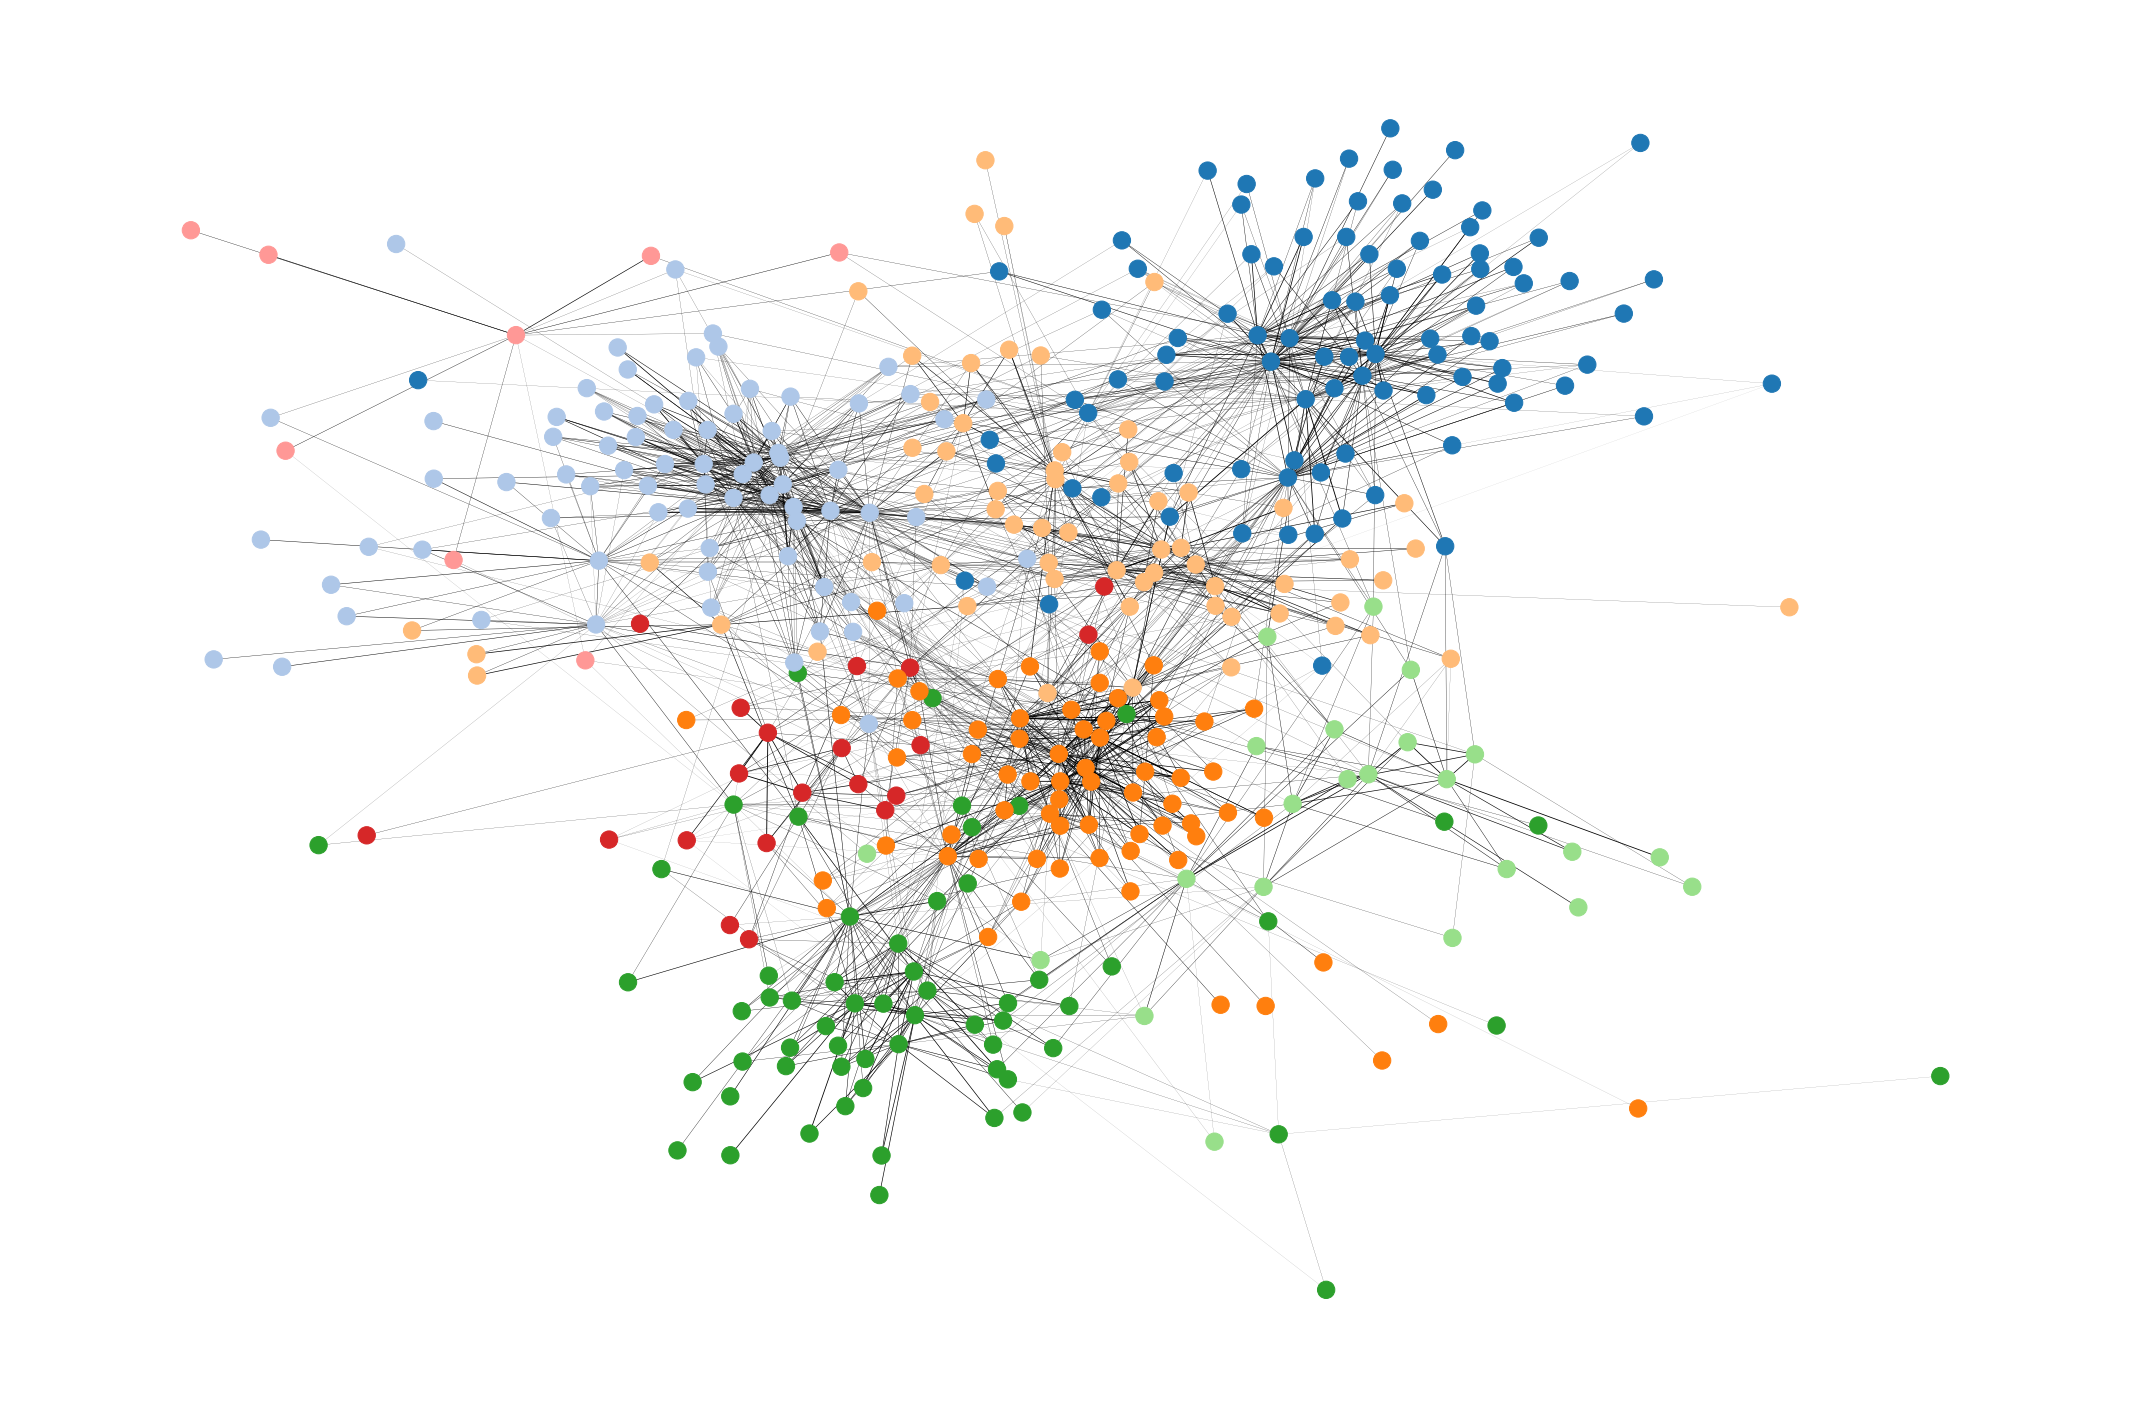

In [185]:
fig, ax = plt.subplots()
nx.draw(plot_subgraph_2, ax = ax, node_color = colors2, width = weights2)
plt.subplots_adjust(-4,-4)
plt.savefig("../files/subgraph2_communities.png", dpi = fig.dpi, bbox_inches='tight')